In [1]:
import ROOT as r
import uproot3
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

Welcome to JupyROOT 6.22/02


/beegfs/desy/user/anovak/miniconda3/envs/coffea/lib/python3.7/site-packages/uproot3/__init__.py:138: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  FutureWarning


In [11]:
a = 0.3
b = 0.1
m = 80
m2 = 91
SF = (m + a)/m
SFe = (m + b)/m
SF, SFe

(1.00375, 1.00125)

In [14]:
SF * m2 - m2, SFe * m2 - m2

(0.34124999999998806, 0.11374999999999602)

In [18]:
a/m * m2, b/m * m2

(0.34125, 0.11375)

In [2]:
fdir = 'fit17ref'
# fdir = 'TestSingle'
# rd = r.TFile.Open('fit_18double/fitDiagnostics.root')
# rd = r.TFile.Open('fit_17cvbcvl/fitDiagnostics.root')
rd = r.TFile.Open(fdir+'/fitDiagnosticsTest.root')


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
rd.Get('fit_s').floatParsFinal()

In [142]:
par_names = rd.Get('fit_s').floatParsFinal().contentsString().split(',')
par_names = [p for p in par_names if 'smear' in p or 'scale' in p  or 'eff' in p]
par_names
out = {}

for pn in par_names:
    out[pn] = {}
    out[pn]['val'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getVal(), 3)
    out[pn]['unc'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getError(), 3)
out

{'CMS_scale': {'val': -1.0, 'unc': 0.051},
 'CMS_smear': {'val': 0.305, 'unc': 0.276},
 'effSF': {'val': 0.883, 'unc': 0.022},
 'effSF_un': {'val': 0.958, 'unc': 0.014},
 'effwSF': {'val': 0.664, 'unc': 0.091},
 'effwSF_un': {'val': 0.964, 'unc': 0.178}}

In [144]:
import json
with open(fdir+'/config.json') as cfg_file:
    cfg = json.load(cfg_file)

In [145]:
out['shift'] = {}
out['shift']['val'] = cfg['scale'] * out['CMS_scale']['val']  # * 1 (template shape)
out['shift']['unc'] = cfg['scale'] * out['CMS_scale']['unc']  # * 1 (template shape)

out['smear'] = {}
out['smear']['val'] = cfg['smear'] * out['CMS_smear']['val']  * 0.5  # (template shape)
out['smear']['unc'] = cfg['smear'] * out['CMS_smear']['unc']  * 0.5 # (template shape)

out

{'CMS_scale': {'val': -1.0, 'unc': 0.051},
 'CMS_smear': {'val': 0.305, 'unc': 0.276},
 'effSF': {'val': 0.883, 'unc': 0.022},
 'effSF_un': {'val': 0.958, 'unc': 0.014},
 'effwSF': {'val': 0.664, 'unc': 0.091},
 'effwSF_un': {'val': 0.964, 'unc': 0.178},
 'shift': {'val': -1.0, 'unc': 0.051},
 'smear': {'val': 0.01525, 'unc': 0.013800000000000002}}

In [146]:
# fd = uproot.open('fitdir/fitDiagnostics.root')
fd = uproot3.open(fdir+'/fitDiagnosticsTest.root')
#fd['shapes_fit_s/wsfpasspass'].keys()

In [147]:
def convTH1(TH1):
    vals = TH1.values
    edges = TH1.edges
    variances = TH1.variances
    vals = vals * np.diff(edges)
    variances = variances * np.diff(edges)
    return vals, edges, variances


def covnTGA(tgasym):
        # https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/wiki/nonstandard
        # Rescale density by binwidth for actual value
        _binwidth = tgasym._fEXlow + tgasym._fEXhigh
        _x = tgasym._fX
        _y = tgasym._fY * _binwidth
        _xerrlo, _xerrhi = tgasym._fEXlow, tgasym._fEXhigh
        _yerrlo, _yerrhi = tgasym._fEYlow * _binwidth, tgasym._fEYhigh * _binwidth
        return _x, _y, [_yerrlo, _yerrhi], [_xerrlo, _xerrhi]
    
def covnTGATH1(tgasym):
        # https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/wiki/nonstandard
        # Rescale density by binwidth for actual value
        _binwidth = tgasym._fEXlow + tgasym._fEXhigh
        _bins = np.r_[tgasym._fX - tgasym._fEXlow, tgasym._fX[-1] + tgasym._fEXlow[-1]]
        _x = tgasym._fX
        _y = tgasym._fY * _binwidth
        _xerrlo, _xerrhi = tgasym._fEXlow, tgasym._fEXhigh
        _yerrlo, _yerrhi = tgasym._fEYlow * _binwidth, tgasym._fEYhigh * _binwidth
        return _y, _bins, ((_yerrhi + _yerrlo)/2)**2
    
# convTH1(fd['shapes_fit_s/wsfPrimaryFail/qcd'])
# covnTGATH1(fd['shapes_fit_s'+'/wsfSecondaryFail/data'])

In [149]:
def th1rat(a, b):
    import scipy.stats
    _coverage1sd = scipy.stats.norm.cdf(1) - scipy.stats.norm.cdf(-1)
    def clopper_pearson_interval(num, denom, coverage=_coverage1sd):
        if np.any(num > denom):
            raise ValueError(
                "Found numerator larger than denominator while calculating binomial uncertainty"
            )
        lo = scipy.stats.beta.ppf((1 - coverage) / 2, num, denom - num + 1)
        hi = scipy.stats.beta.ppf((1 + coverage) / 2, num + 1, denom - num)
        interval = np.array([lo, hi])
        interval[:, num == 0.0] = 0.0
        interval[1, num == denom] = 1.0
        return interval

    sumw_num, edges, sumw2_num = a
    sumw_denom, edges, sumw2_denom = b

    rsumw = sumw_num / sumw_denom
    rsumw_err = np.abs(
        clopper_pearson_interval(sumw_num, sumw_num + sumw_denom) - rsumw)
            
    return rsumw, edges, rsumw_err
            
# r, e, err = th1rat(covnTGATH1(fd['shapes_fit_s'+'/wsfSecondaryFail/data']), convTH1(fd['shapes_fit_s'+'/wsfSecondaryFail/total']))

# plt.filL-between(e[:-1], r, err)

In [150]:
plt.style.use([hep.style.ROOT])

In [156]:
if '16' in cfg['out']:
    year = '2016'
elif '17' in cfg['out']:
    year = '2017'
elif '18' in cfg['out']:
    year = '2018'

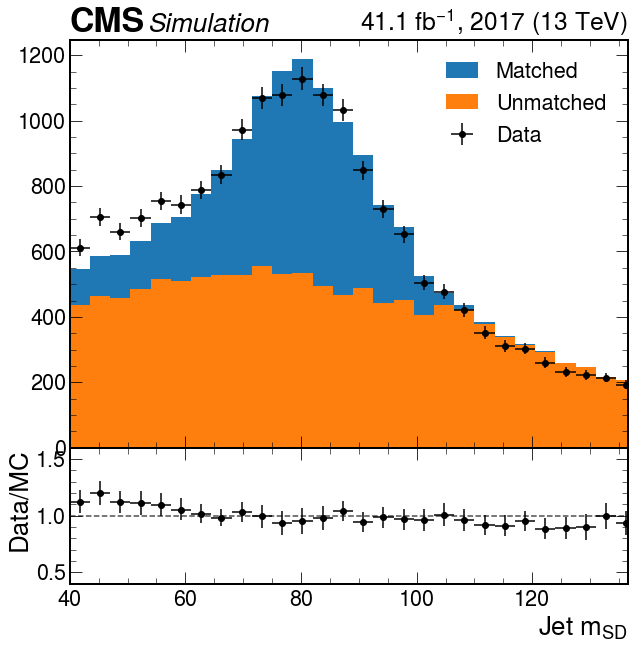

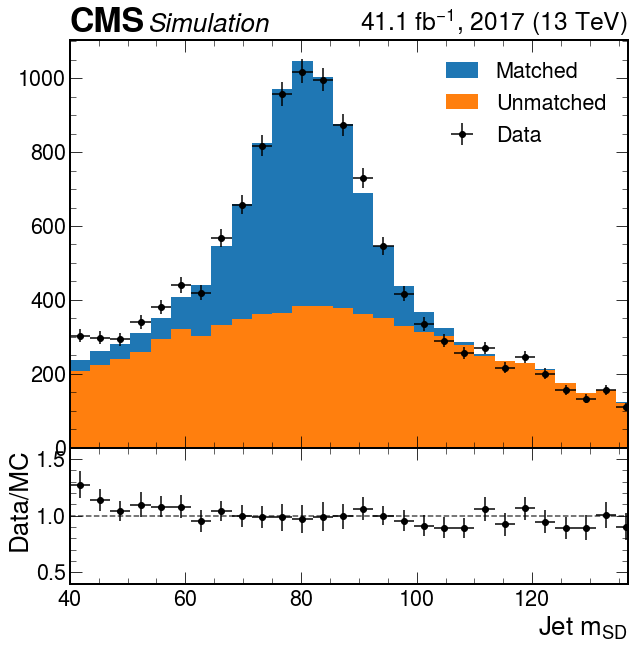

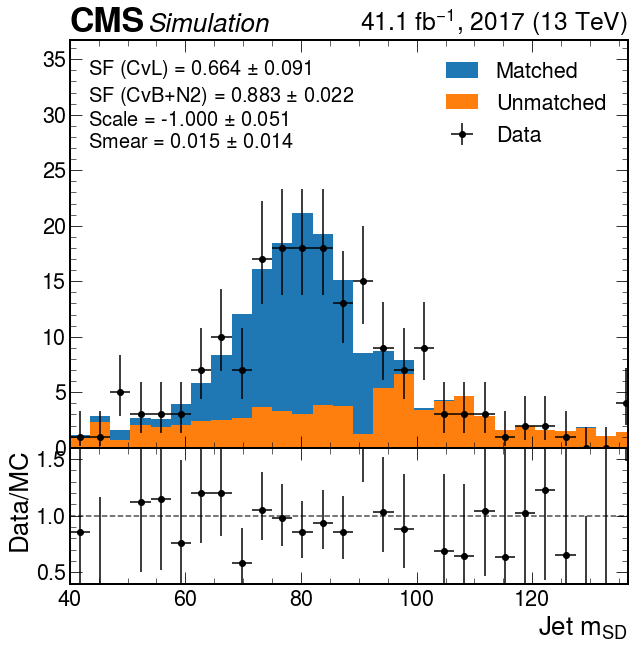

In [158]:
shapetype = 'shapes_fit_s'
regions = [r.decode('utf').replace(";1", '') for r in fd['shapes_fit_s'].keys()]

lumi = {
    "mu": {
        "2016": 35.2,
        "2017": 41.1,
        "2018": 59.0,
    }
}

for i, reg in enumerate(regions):
    f, (ax, rax) = plt.subplots(2,1, figsize=(10, 10), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
    f.subplots_adjust(hspace=0)

    ho1 = convTH1(fd[shapetype+'/'+reg+'/qcd'])
    ho2 = convTH1(fd[shapetype+'/'+reg+'/wqq'])
    tgo = covnTGA(fd[shapetype+'/'+reg+'/data'])
    
    tgoh = covnTGATH1(fd[shapetype+'/'+reg+'/data'])
    htot = convTH1(fd[shapetype+'/'+reg+'/total'])
    
    ax.errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', color='black', label='Data')
    hep.histplot([ho1[0], ho2[0]], ho1[1], stack=True, ax=ax, label=['Unmatched', "Matched"], histtype='fill')

    ax.set_xlim(40, 136.5)
    ax.set_ylabel('Ev')
    ax.legend()

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc1 =  unumpy.uarray(ho1[0], ho1[2])
    mc2 =  unumpy.uarray(ho2[0], ho2[2])
    ratio = data/(mc1 + mc2)

    rax.errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')
    rax.hlines(1, 40, 150, linestyle='--', color='k', alpha=0.7)
    rax.set_ylim(0.4, 1.6)
    rax.set_ylabel("Data/MC")
    rax.set_xlabel("Jet $m_{SD}$", x=1, ha='right');
    
    hep.cms.label(ax=ax, year=year, lumi=lumi['mu'][year])
    
ax.set_ylim(None, ax.get_ylim()[-1]*1.5)    
if "Secondary" in reg:
    sfstr = ("SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effwSF']['val'], out['effwSF']['unc'])
         + "\nSF (CvB+N2) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['shift']['val'], out['shift']['unc'])
         + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
else:
    sfstr = (
             "SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
             + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['shift']['val'], out['shift']['unc'])
             + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
            )
    
at = AnchoredText(sfstr,
              loc='upper left', frameon=False, prop=dict(size=20)
              )
ax.add_artist(at);


In [139]:
from scalesmear import AffineMorphTemplate

In [152]:
base = AffineMorphTemplate(fd['shapes_prefit'+'/wsfSinglePass/wqq'].numpy())
res = AffineMorphTemplate(fd['shapes_fit_s'+'/wsfSinglePass/wqq'].numpy())
base.scale(out['effSF']['val'])

def rms(ref, other):
    return np.sqrt(np.mean((ref - other)**2))
    
def rmsev(x):
    return rms(res.get()[0], base.get(shift=x[0], scale=x[1])[0])

from scipy.optimize import minimize

x0 = [0, 1]
fit_res = minimize(rmsev, x0, method='Nelder-Mead', tol=1e-6)
fit_res.x

array([-1.73290724,  1.06111519])

In [156]:
%matplotlib inline

In [159]:
plt.style.use([hep.style.ROOT, {'font.size': 23}])

base_temp = fd['shapes_prefit'+'/wsfSinglePass/wqq'].numpy()
base = AffineMorphTemplate(fd['shapes_prefit'+'/wsfSinglePass/wqq'].numpy())
res = AffineMorphTemplate(fd['shapes_fit_s'+'/wsfSinglePass/wqq'].numpy())
base.scale(out['effSF']['val'])
    
def nplot(shift=0, smear=1):
    measured = [0, 1]
    measured[0] = out['CMS_scale']['val'] * cfg['scale']
    measured[1] = 1 + out['CMS_smear']['val'] * 0.5 * cfg['smear']
    # Fit
    x0 = [0, 1]
    fit_res = minimize(rmsev, x0, method='SLSQP', tol=1e-8)
    best_fit = fit_res.x
    fig, ax = plt.subplots()
    hep.histplot(base.get(), label='Base', ls='-', color='black', alpha=1)
    hep.histplot(base.get(shift=shift, scale=smear), label='Interactive', ls='--')
    hep.histplot(base.get(shift=best_fit[0], scale=best_fit[1]), label='Best Fit', ls='--', color='k', alpha=0.6)
    hep.histplot(res.get(), label='Combine Result', ls=':', color='r')
    info = "Measured\nShift: {:.3f}\nSmear: {:.3f}".format(*measured)
    info += "\nRMS: {:.3f}".format(np.mean(np.sqrt(abs(res.get()[0] - base.get(shift=measured[0], scale=measured[1])[0]))))
    info += "\n\nBest Fit\nShift: {:.3f}\nSmear: {:.3f}".format(best_fit[0], best_fit[1])
    info += "\nRMS: {:.3f}".format(np.mean(np.sqrt(abs(res.get()[0] - base.get(shift=best_fit[0], scale=measured[1])[0]))))
    info += "\n\nInteractive\nShift: {:.3f}\nSmear: {:.3f}".format(shift, smear)
    info += "\nRMS: {:.3f}".format(np.mean(np.sqrt(abs(res.get()[0] - base.get(shift=shift, scale=smear)[0]))))
    
    at_left = AnchoredText(info,
                  loc='upper left', frameon=False, prop=dict(size=16))
    ax.add_artist(at_left);
    plt.legend()

In [160]:
from ipywidgets import interactive, GridBox, Layout, FloatSlider, ToggleButton

iplot = interactive(
    nplot,
    shift = FloatSlider(min=-5, max=5, step=0.1, value=0),
    smear = FloatSlider(min=0.6, max=1.4, step=0.01, value=1),
#     fit = ToggleButton(
#         value=False,
#         description='RMS Fit',
#         disabled=False,
#         button_style='info', # 'success', 'info', 'warning', 'danger' or ''
#         icon='check' # (FontAwesome names without the `fa-` prefix)
#     ),
)

controls = GridBox(iplot.children[:-1], layout=Layout(grid_template_columns="repeat(3, 300px)"))
display(controls, iplot.children[-1])

GridBox(children=(FloatSlider(value=0.0, description='shift', max=5.0, min=-5.0), FloatSlider(value=1.0, descr…

Output()

In [182]:
fd[shapetype+'/wsfSecondaryPass'].keys()

[b'data;1',
 b'qcd;1',
 b'wqq;1',
 b'total;1',
 b'total_signal;1',
 b'total_background;1',
 b'total_covar;1']

In [185]:
fd[shapetype+'/wsfSecondaryPass/total_background'].variances

array([0.01323271, 0.12397775, 0.00710637, 0.04495498, 0.05215261,
       0.04567346, 0.06370119, 0.06023424, 0.09906839, 0.11905061,
       0.08868723, 0.15797332, 0.10054666, 0.13116082, 0.02690855,
       0.24285547, 0.27629026, 0.07200441, 0.16217163, 0.12836672,
       0.0698901 , 0.03696023, 0.0397475 , 0.0310265 , 0.0357758 ,
       0.05920429, 0.0296381 , 0.02082042, 0.02682395, 0.02179265])

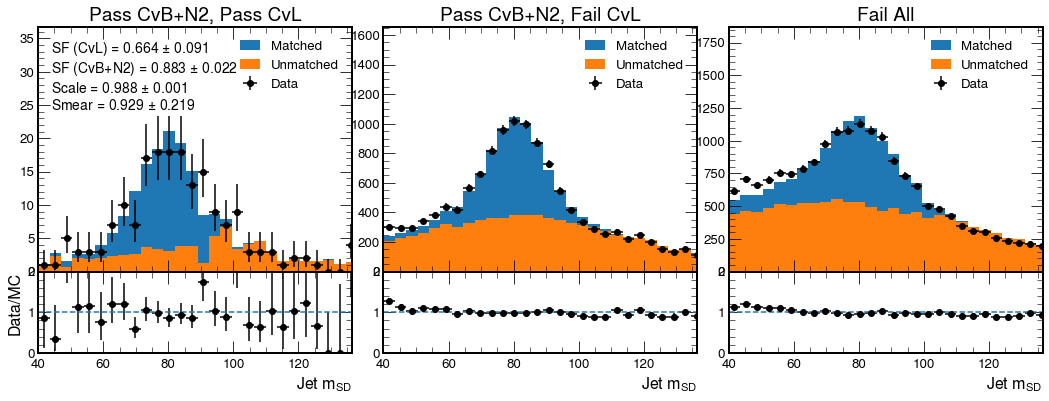

In [178]:
shapetype = 'shapes_fit_s'

f, (ax1, ax2) = plt.subplots(2,3, figsize=(18, 6), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.1)

for i, reg in enumerate(['wsfSecondaryPass', 'wsfSecondaryFail', 'wsfPrimaryFail']):
    ho1 = convTH1(fd[shapetype+'/'+reg+'/qcd'])
    ho2 = convTH1(fd[shapetype+'/'+reg+'/wqq'])
    tgo = covnTGA(fd[shapetype+'/'+reg+'/data'])
    
    ax1[i].errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', color='black', label='Data')
    hep.histplot([ho1[0], ho2[0]], ho1[1], stack=True, ax=ax1[i], label=['Unmatched', "Matched"], histtype='fill')

    ax1[i].set_xlim(40, 136.5)
    ax1[i].legend()

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc1 =  unumpy.uarray(ho1[0], ho1[2])
    mc2 =  unumpy.uarray(ho2[0], ho2[2])
    ratio = data/(mc1 + mc2)

    ax2[i].errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')
    ax2[i].hlines(1, 40, 150, linestyle='--')
    ax2[i].set_ylim(0, 2)
    if i == 0:
        #hep.cms.cmslabel(ax=ax1[i],  rlabel="")
        ax2[i].set_ylabel("Data/MC")
    ax2[i].set_xlabel("Jet $m_{SD}$", x=1, ha='right');
    ax1[0].set_title('Pass CvB+N2, Pass CvL')
    ax1[1].set_title('Pass CvB+N2, Fail CvL')
    ax1[2].set_title('Fail All')
    ax1[i].set_ylim(None, ax1[i].get_ylim()[-1]*1.5)
    
sfstr = ("SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effwSF']['val'], out['effwSF']['unc'])
         + "\nSF (CvB+N2) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['scale']['val'], out['scale']['unc'])
         + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
    
at = AnchoredText(sfstr,
              loc='upper left', frameon=False, prop=dict(size=14)
              )
ax1[0].add_artist(at);


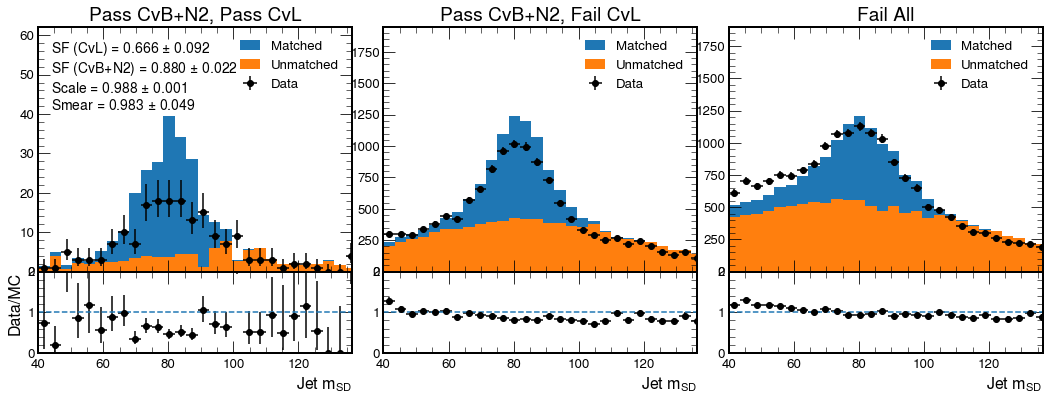

In [15]:
shapetype = 'shapes_prefit'

f, (ax1, ax2) = plt.subplots(2,3, figsize=(18, 6), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.1)

for i, reg in enumerate(['wsfSecondaryPass', 'wsfSecondaryFail', 'wsfPrimaryFail']):
    ho1 = convTH1(fd[shapetype+'/'+reg+'/qcd'])
    ho2 = convTH1(fd[shapetype+'/'+reg+'/wqq'])
    tgo = covnTGA(fd[shapetype+'/'+reg+'/data'])
    
    ax1[i].errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', color='black', label='Data')
    hep.histplot([ho1[0], ho2[0]], ho1[1], stack=True, ax=ax1[i], label=['Unmatched', "Matched"], histtype='fill')

    ax1[i].set_xlim(40, 136.5)
    ax1[i].legend()

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc1 =  unumpy.uarray(ho1[0], ho1[2])
    mc2 =  unumpy.uarray(ho2[0], ho2[2])
    ratio = data/(mc1 + mc2)

    ax2[i].errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')
    ax2[i].hlines(1, 40, 150, linestyle='--')
    ax2[i].set_ylim(0, 2)
    if i == 0:
        #hep.cms.cmslabel(ax=ax1[i],  rlabel="")
        ax2[i].set_ylabel("Data/MC")
    ax2[i].set_xlabel("Jet $m_{SD}$", x=1, ha='right');
    ax1[0].set_title('Pass CvB+N2, Pass CvL')
    ax1[1].set_title('Pass CvB+N2, Fail CvL')
    ax1[2].set_title('Fail All')
    ax1[i].set_ylim(None, ax1[i].get_ylim()[-1]*1.5)
    
sfstr = ("SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effwSF']['val'], out['effwSF']['unc'])
         + "\nSF (CvB+N2) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['scale']['val'], out['scale']['unc'])
         + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
    
at = AnchoredText(sfstr,
              loc='upper left', frameon=False, prop=dict(size=14)
              )
ax1[0].add_artist(at);


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2b2d13572990>, errorbar=None, legend_artist=None)]

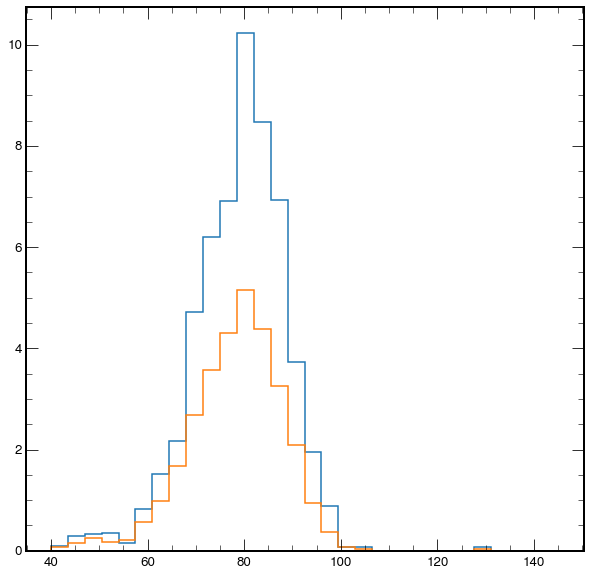

In [20]:
hep.histplot(fd['shapes_prefit'+'/wsfSecondaryPass/wqq'].numpy())
hep.histplot(fd['shapes_fit_s'+'/wsfSecondaryPass/wqq'].numpy())

In [79]:
import os, uproot3
import mplhep as hep

In [74]:
os.listdir('xC')

['plots_datamc',
 'sf_datacard_T_n2_hbb_04_incl_alt.txt',
 'sf_fitDiagnostics_T_n2_hbb_04_incl_alt.root',
 'sf_T_n2_hbb_04_incl_alt.root',
 'T_n2_hbb_04_incl_pass_alt.root',
 'sf_T_n2_hbb_04_incl.root',
 'T_n2_hbb_04_incl_alt_pass.root',
 'combine_logger.out',
 'makeSFDatacard.C',
 'T_n2_hbb_04_incl_pass.root',
 'T_n2_hbb_04_incl_alt_fail.root',
 'sf_fitDiagnostics_T_n2_hbb_04_incl.root',
 'higgsCombineTest.MultiDimFit.mH125.root',
 'T_n2_hbb_04_incl_fail.root',
 'T_n2_hbb_04_incl_fail_alt.root',
 'sf_datacard_T_n2_hbb_04_incl.txt',
 'higgsCombineTest.FitDiagnostics.mH125.root']

In [121]:
fp = uproot3.open('xC/T_n2_hbb_04_incl_alt_pass.root')
ff = uproot3.open('xC/T_n2_hbb_04_incl_alt_fail.root')
fp.keys(), ff.keys()

([b'data_obs;1',
  b'catp1;1',
  b'catp2;1',
  b'catp2_central;1',
  b'catp2_smearDown;1',
  b'catp2_smearUp;1',
  b'catp2_scaleDown;1',
  b'catp2_scaleUp;1'],
 [b'data_obs;1',
  b'catp1;1',
  b'catp2;1',
  b'catp2_central;1',
  b'catp2_smearDown;1',
  b'catp2_smearUp;1',
  b'catp2_scaleDown;1',
  b'catp2_scaleUp;1'])

In [124]:
fout = uproot3.recreate('xC/renamed_T_n2_hbb_04_incl_alt.root')
fout['data_obs_pass_nominal'] = fp['data_obs']
fout['data_obs_fail_nominal'] = ff['data_obs']
fout['catp1_pass_nominal'] = fp['catp1']
fout['catp1_fail_nominal'] = ff['catp1']
fout['catp2_pass_nominal'] = fp['catp2']
fout['catp2_fail_nominal'] = ff['catp2']
fout['catp2_pass_smearDown'] = fp['catp2_smearDown']
fout['catp2_fail_smearDown'] = ff['catp2_smearDown']
fout['catp2_pass_smearUp'] = fp['catp2_smearUp']
fout['catp2_fail_smearUp'] = ff['catp2_smearUp']
fout['catp2_pass_scaleDown'] = fp['catp2_scaleDown']
fout['catp2_fail_scaleDown'] = ff['catp2_scaleDown']
fout['catp2_pass_scaleUp'] = fp['catp2_scaleUp']
fout['catp2_fail_scaleUp'] = ff['catp2_scaleUp']
fout.keys()
fout.close()

In [120]:
uproot3.open('newbasew17/wtemplates_n2cvb_var.root').keys()

[b'catp2_pass_nominal;1',
 b'catp2_pass_smearDown;1',
 b'catp2_pass_smearUp;1',
 b'catp2_pass_scaleDown;1',
 b'catp2_pass_scaleUp;1',
 b'data_obs_pass_nominal;1',
 b'catp1_pass_nominal;1',
 b'data_obs_fail_nominal;1',
 b'catp1_fail_nominal;1',
 b'catp2_fail_nominal;1',
 b'catp2_fail_smearDown;1',
 b'catp2_fail_smearUp;1',
 b'catp2_fail_scaleDown;1',
 b'catp2_fail_scaleUp;1']

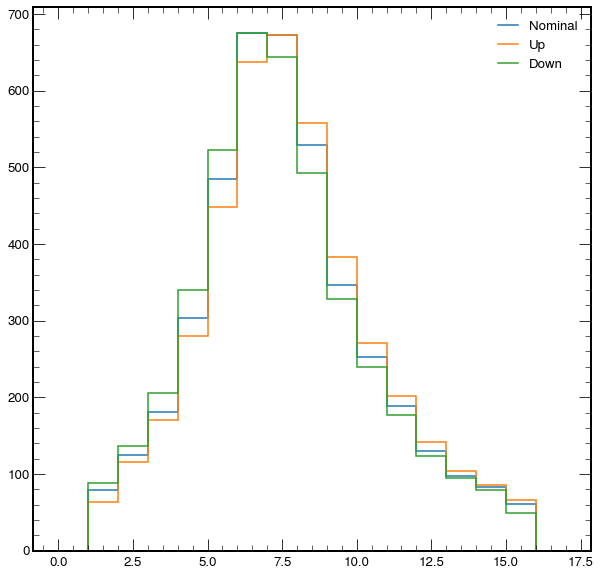

In [118]:
fu = uproot3.open('xC/T_n2_hbb_04_incl_alt_fail.root')
fu.keys()
hep.histplot(fu['catp2_central'], label='Nominal')
hep.histplot(fu['catp2_scaleUp'], label='Up')
hep.histplot(fu['catp2_scaleDown'], label='Down')
plt.legend()

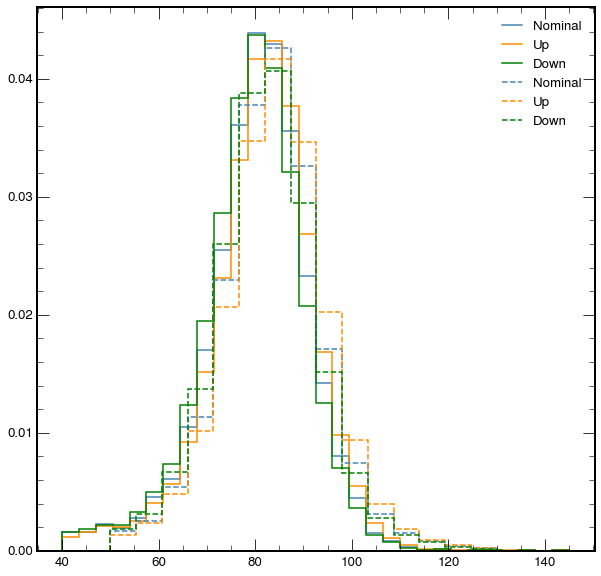

In [112]:
fr = uproot3.open('xC/T_n2_hbb_04_incl_pass_alt.root')
fu = uproot3.open('newbasew17/wtemplates_n2cvb_var.root')

cs = ['steelblue', 'darkorange', 'green']

dense = True
hep.histplot(fu['catp2_pass_nominal'].numpy(), label='Nominal', color=cs[0], density=dense)
hep.histplot(fu['catp2_pass_scaleUp'].numpy(), label='Up', color=cs[1], density=dense)
hep.histplot(fu['catp2_pass_scaleDown'].numpy(), label='Down', color=cs[2], density=dense)

hep.histplot(fr['catp2_central'].values, fr['catp2_central'].edges, label='Nominal', ls='--', color=cs[0], density=dense)
hep.histplot(fr['catp2_scaleUp'].values, fr['catp2_scaleUp'].edges, label='Up', ls='--', color=cs[1], density=dense)
hep.histplot(fr['catp2_scaleDown'].values, fr['catp2_scaleDown'].edges, label='Down', ls='--', color=cs[2], density=dense)
plt.legend()

In [109]:
fr['catp2_central'].edges

array([ 50.        ,  55.33333333,  60.66666667,  66.        ,
        71.33333333,  76.66666667,  82.        ,  87.33333333,
        92.66666667,  98.        , 103.33333333, 108.66666667,
       114.        , 119.33333333, 124.66666667, 130.        ])

In [150]:
f1 = uproot3.open(fdir+'/scale05.root')
f2 = uproot3.open(fdir+'/scale1.root')
f3 = uproot3.open(fdir+'/scale2.root')

fs1 = uproot3.open(fdir+'/smear01.root')
fs2 = uproot3.open(fdir+'/smear05.root')
fs3 = uproot3.open(fdir+'/scale1.root')


Text(0.5, 1.0, 'Post Fit Shapes')

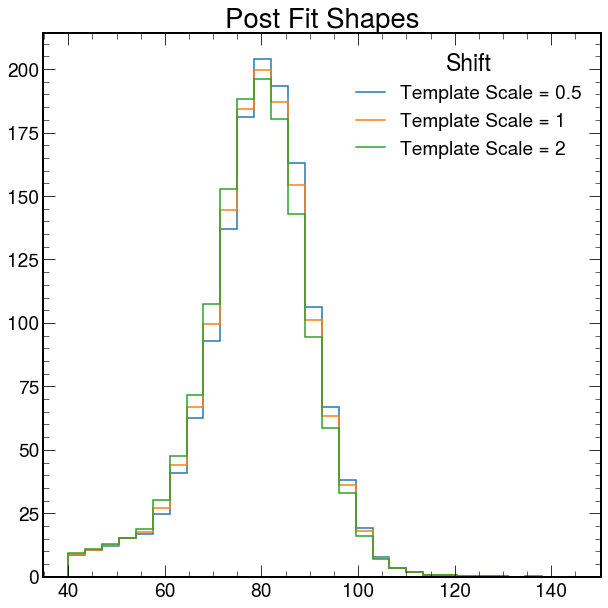

In [148]:
for fi, sc in zip([f1, f2, f3], [0.5, 1, 2]):
    hep.histplot(fi['shapes_fit_s'+'/wsfSinglePass/wqq'].numpy(), label='Template Scale = {}'.format(sc))
plt.legend(title="Shift")
plt.title("Post Fit Shapes")

Text(0.5, 1.0, 'Post Fit Shapes')

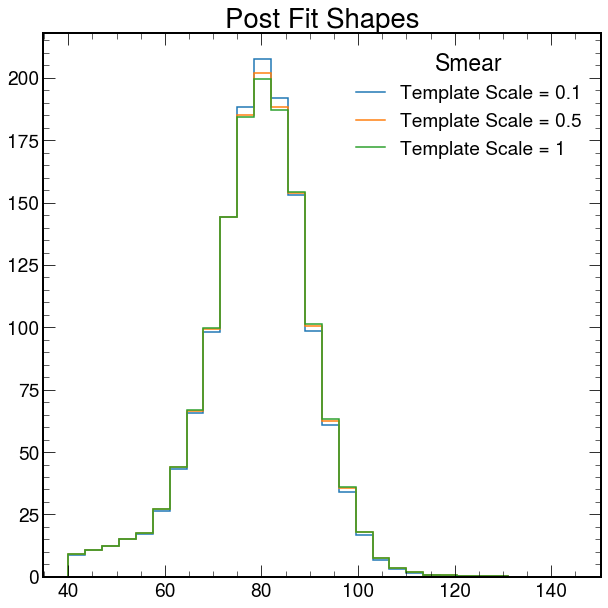

In [151]:
for fi, sc in zip([fs1, fs2, fs3], [0.1, 0.5, 1]):
    hep.histplot(fi['shapes_fit_s'+'/wsfSinglePass/wqq'].numpy(), label='Template Scale = {}'.format(sc))
plt.legend(title="Smear")
plt.title("Post Fit Shapes")